In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

PROJECT_ROOT_DIR = "latent-communication"
current_dir = os.getcwd()
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")

**Path definition**
Define here the paths where your different databases are saved

In [ ]:
PATH1 = "results/transformations/calculations_databases/PCKTAE_class.csv"
PATH2 = "results/transformations/calculations_databases/PCKTAE_top.csv"
PATH3 = "results/transformations/calculations_databases/PCKTAE_error_distribution.csv"

# General Analyisis

Here the plots generated use only the MSE loss under different conditions. Run this to have a general overview of the various models

Text(0, 0.5, 'MSE Loss')

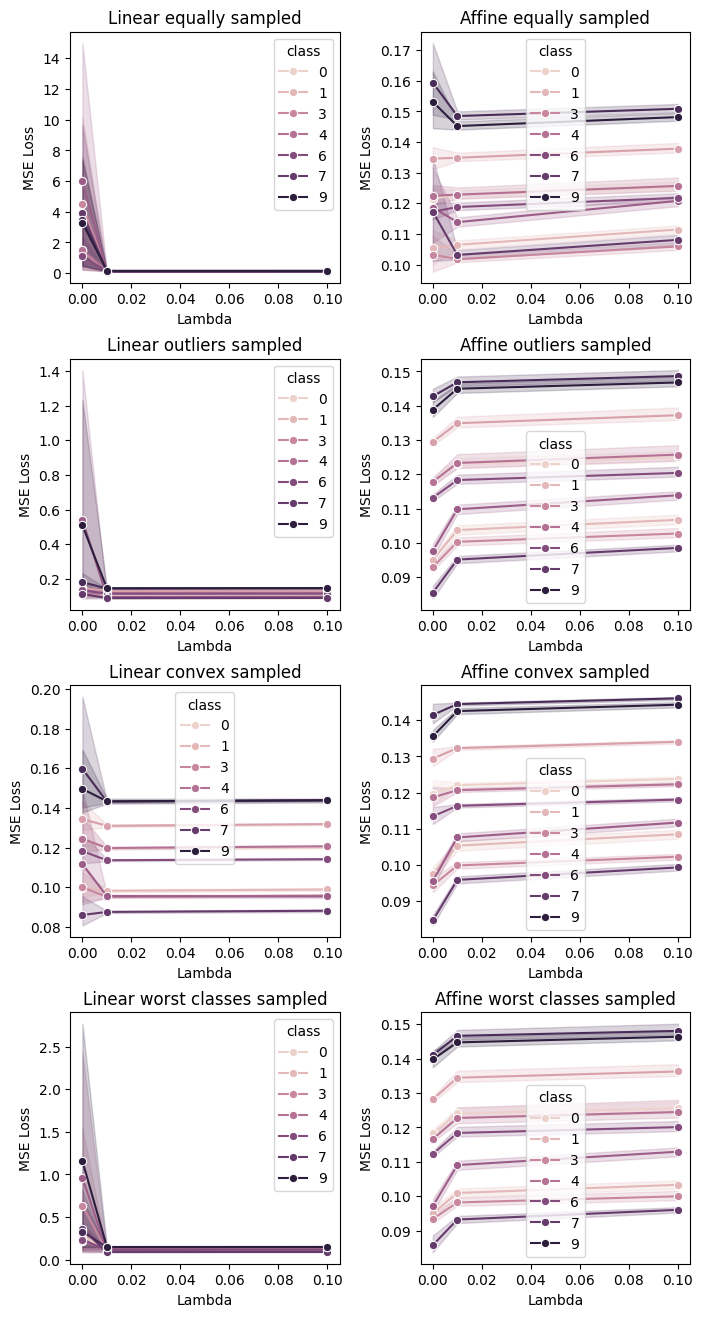

In [31]:
results = pd.read_csv(os.path.join(current_dir, PATH1), sep='#')

results['original loss'] = results['MSE_loss']
results['MSE_loss'] = results['MSE_loss']

results = results[results['latent_dim'] == 50]

plt.figure(figsize=(8, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
# Plot MSE_loss vs. lambda
plt.subplot(4, 2, 1)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'equally')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Linear equally sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 2)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'equally')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Affine equally sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 3)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'outliers')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Linear outliers sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 4)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'outliers')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Affine outliers sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 5)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'convex_hull')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Linear convex sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 6)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'convex_hull')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Affine convex sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 7)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'worst_classes')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Linear worst classes sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 8)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'worst_classes')], x='lambda', y='MSE_loss', marker='o', hue='class')
plt.title('Affine worst classes sampled')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')


Text(0, 0.5, 'MSE Loss')

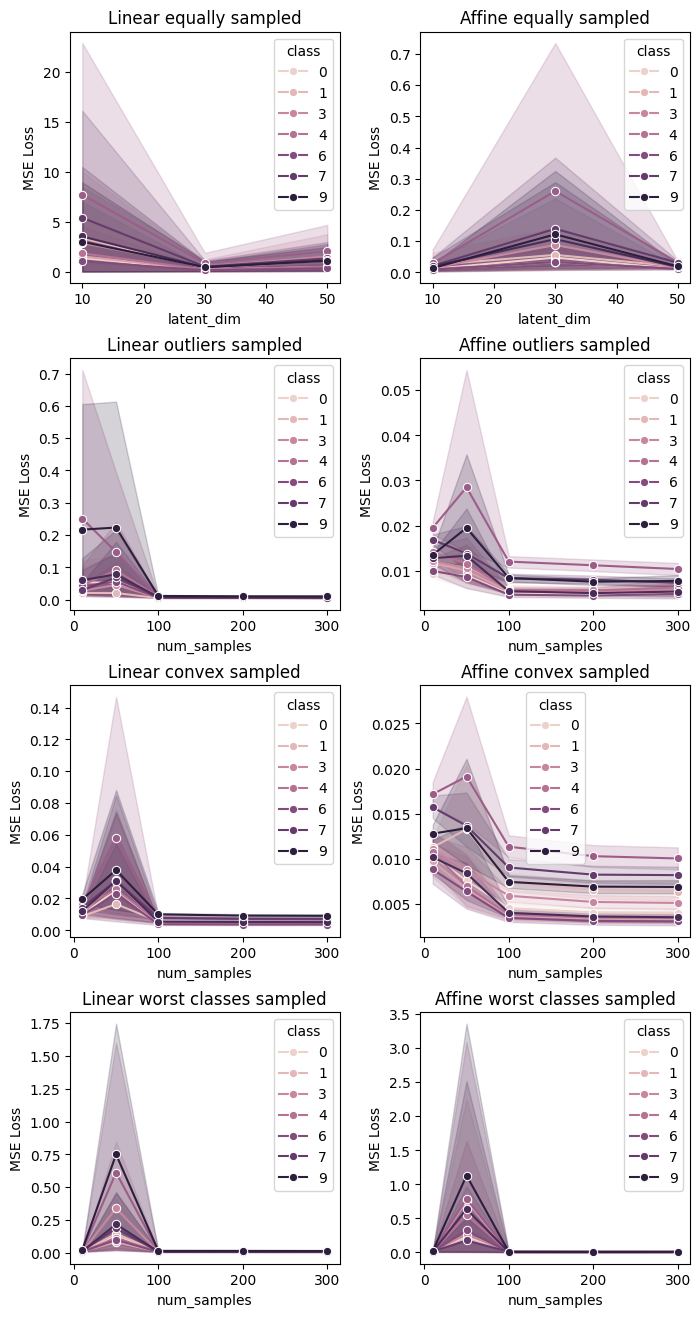

In [ ]:
results = pd.read_csv(os.path.join(current_dir, PATH1), sep='#')

results['original loss'] = results['MSE_loss']
results['MSE_loss'] = results['MSE_loss'] - results['MSE_loss_model2']

plt.figure(figsize=(8, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
# Plot MSE_loss vs. lambda
plt.subplot(4, 2, 1)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'equally')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Linear equally sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 2)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'equally')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Affine equally sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 3)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'outliers')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Linear outliers sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 4)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'outliers')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Affine outliers sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 5)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'convex_hull')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Linear convex sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 6)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'convex_hull')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Affine convex sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 7)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'worst_classes')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Linear worst classes sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 8)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'worst_classes')], x='num_samples', y='MSE_loss', marker='o', hue='class')
plt.title('Affine worst classes sampled')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')

Text(0, 0.5, 'MSE Loss')

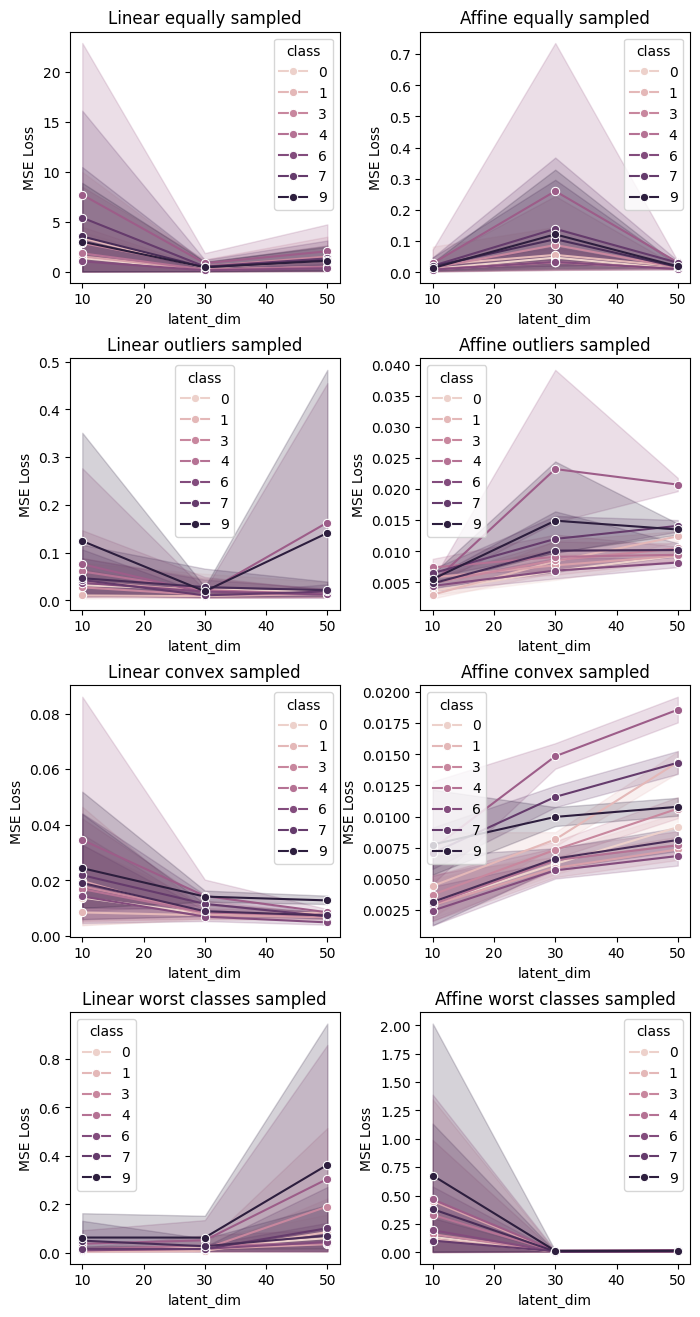

In [ ]:
results = pd.read_csv(os.path.join(current_dir, PATH1), sep='#')

results['original loss'] = results['MSE_loss']
results['MSE_loss'] = results['MSE_loss'] - results['MSE_loss_model2']

plt.figure(figsize=(8, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
# Plot MSE_loss vs. lambda
plt.subplot(4, 2, 1)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'equally')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Linear equally sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 2)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'equally')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Affine equally sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 3)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'outliers')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Linear outliers sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 4)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'outliers')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Affine outliers sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 5)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'convex_hull')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Linear convex sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 6)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'convex_hull')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Affine convex sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 7)
sns.lineplot(data=results[(results['mapping'] == 'Linear') & (results['sampling_strategy'] == 'worst_classes')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Linear worst classes sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

plt.subplot(4, 2, 8)
sns.lineplot(data=results[(results['mapping'] == 'Affine') & (results['sampling_strategy'] == 'worst_classes')], x='latent_dim', y='MSE_loss', marker='o', hue='class')
plt.title('Affine worst classes sampled')
plt.xlabel('latent_dim')
plt.ylabel('MSE Loss')

# Error analysis

Dataset preparation

In [21]:
from scipy.stats import norm

results = pd.read_csv(os.path.join(current_dir, PATH3), sep='#')
results[['mapping', 'latent_dim', 'lambda', 'sampling_strategy']] = results['model'].str.extract(r'.*>(Affine|Linear)_(\d+)_(\d+(?:\.\d+)?)_([a-z_]+)')
results.groupby('model') 

results['variance'] = results['variance'] + results['parent_right_variance']
results['mean'] = results['mean'] - results['parent_right_mean']


DTypePromotionError: The DType <class 'numpy.dtypes._PyFloatDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes.StrDType'>, <class 'numpy.dtypes._PyFloatDType'>)

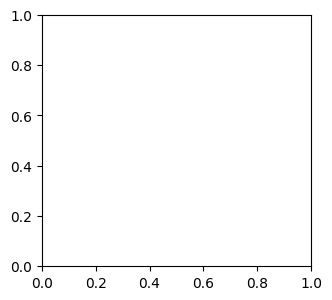

In [25]:
plt.figure(figsize=(8, 16))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
# Plot MSE_loss vs. lambda

list_def = [("Linear", "equally"), ("Linear", "outliers"), ("Linear", "convex_hull"), ("Linear", "worst_classes"),
    ("Affine", "equally"), ("Affine", "outliers"), ("Affine", "convex_hull"), ("Affine", "worst_classes")]

for i, (mapping, sampling_strategy) in enumerate(list_def):
    ax = plt.subplot(4, 2, i+1)
    subset = results[(results['mapping'] == mapping) & (results['sampling_strategy'] == sampling_strategy)]
    for class_label in subset['class'].unique():
        class_subset = subset[subset['class'] == class_label]
        mean = class_subset['mean'].mean()
        std_dev = class_subset['variance'].mean() ** 0.5
        x = np.linspace(class_subset['lambda'].min(), class_subset['lambda'].max(), 100)
        y = norm.pdf(x, mean, std_dev)

        sns.lineplot(x=x, y=y, label=class_label, ax=ax)
    x = np.linspace(results['lambda'].min(), results['lambda'].max(), 100)
    y = norm.pdf(x, mean, std_dev)

    sns.lineplot(x=x, y=y, label=class_label, ax=ax)

    plt.title(f"{mapping} {sampling_strategy.replace('_', ' ')}")
    plt.xlabel('Lambda')
    plt.ylabel('Probability Density')
    plt.legend()

plt.show()

In [28]:
print(results[results['mean'].apply(lambda x: isinstance(x, str))])  # Check for string means



Empty DataFrame
Columns: [Unnamed: 0, model, class, parent_left_mean, parent_left_variance, parent_right_mean, parent_right_variance, mean, variance, mapping, latent_dim, lambda, sampling_strategy, distribution]
Index: []


In [ ]:

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. latent dimension
plt.subplot(2, 2, 4)
# Change opacity of the boxplot
temp_res = results.copy()

# Function to safely extract the third part
def extract_third_part(s):
    parts = s.split('_')
    print(parts)
    if len(parts) >= 3:
        return parts[2]
    else:
        return None  # Or any default value you prefer

temp_res['latent_dim'] = temp_res['model2'].apply(extract_third_part)


sns.lineplot(data=temp_res, x='latent_dim', y='MSE_loss_model2')

plt.title('MSE Loss of Model2 and Model1')
plt.xlabel('Model')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

In [ ]:
# Use different colors for each class blue

#sns.set_palette(sns.color_palette("tab10"))

# Plot MSE_loss per class vs. lambda
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.lineplot(data=results_class, x='lambda', y='MSE_loss', marker='o', hue='class', err_style='bars')
# Make Variance of the lineplot not visible


plt.title('MSE Loss per Class vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results_class, x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')
plt.title('MSE Loss per Class vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss per class vs. mapping
plt.subplot(2, 2, 3)
sns.boxplot(data=results_class, x='mapping', y='MSE_loss', hue='class')
plt.title('MSE Loss per Class vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Plot class outliers for each class 
plt.subplot(2, 2, 4)
sns.barplot(data=results_class, x='class', y='MSE_loss_model2', color='purple', alpha=0.5)
sns.barplot(data=results_class, x='class', y='MSE_loss_model1', color='orange', fill=None, linewidth=2)

plt.title('MSE Loss per Class for Model2 and Model1')
plt.xlabel('Class')
plt.ylabel('MSE Loss')


# Show all plots
plt.tight_layout()
plt.show()

In [ ]:
################################################
filter = {
    "model1": "models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE_10_2.pth",
    "model2": "models/checkpoints/PCKTAE/FMNIST/FMNIST_PCKTAE_10_1.pth",
    "mapping": "Linear",
    "lambda": 0.01,
    "num_samples": 100,
    "dataset": "FMNIST"
}
################################################



print(results_top.describe())

# Get results top for the filter
results_top_filtered = results_top[(results_top["model1"] == filter["model1"]) & (results_top["model2"] == filter["model2"]) & (results_top["mapping"] == filter["mapping"]) & (results_top["lambda"] == filter["lambda"]) & (results_top["num_samples"] == filter["num_samples"]) & (results_top["dataset"] == filter["dataset"])]

# Add a new column for the x-axis index
results_top_filtered = results_top_filtered.reset_index(drop=True)
results_top_filtered['index'] = results_top_filtered.index + 1

print(results_top_filtered)
# Random indices for sampling
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(results_top_filtered.index, 100, replace=False)

# Take only the random indices
results_top_filtered_sampled = results_top_filtered.loc[random_indices]

# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model1', marker='o', color='blue', label='Model 1')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_model2', marker='o', color='orange', label='Model 2')
sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Reconstruction per Sample Stitched vs. Model 1')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.legend()

# Get indices of the top 5% of each model
top_indices_model1 = results_top_filtered_sampled[results_top_filtered_sampled["model1_top"] == True]
top_indices_model2 = results_top_filtered_sampled[results_top_filtered_sampled["model2_top"] == True]
top_indices_stitched = results_top_filtered_sampled[results_top_filtered_sampled["stitched_top"] == True]

# Convert the indices to numpy arrays
top_indices_model1_array = top_indices_model1.index.to_numpy()
top_indices_model2_array = top_indices_model2.index.to_numpy()
top_indices_stitched_array = top_indices_stitched.index.to_numpy()

# Intersection of all the top indices that are in the top 5% of all models
intersection_top = np.intersect1d(top_indices_model1_array, top_indices_stitched_array)
intersection_top_mod2 = np.intersect1d(top_indices_model2_array, top_indices_model2_array)

# Add color column to DataFrame
results_top_filtered['color_model1'] = 'blue'
results_top_filtered.loc[intersection_top, 'color_model1'] = 'red'
results_top_filtered['color_model2'] = 'blue'
results_top_filtered.loc[intersection_top_mod2, 'color_model2'] = 'red'



plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model1_array], x='index', y='reconstruction_error_model1', hue='color_model1', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 1 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.subplot(2, 2, 4)
# Use as x the index of the datapoints
sns.scatterplot(data=results_top_filtered.loc[top_indices_model2_array], x='index', y='reconstruction_error_model2', hue='color_model2', palette={'blue': 'blue', 'red': 'red'}, legend=False)
sns.scatterplot(data=results_top_filtered.loc[top_indices_stitched_array], x='index', y='reconstruction_error_stitched', marker='x', color='green', legend=False)
plt.title('Reconstruction per Sample for Top 5% Model 2 and Stitched')
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')

plt.tight_layout()
plt.show()






In [ ]:
# Plot the influence on the latent space 
results_top_filtered_sampled = results_top_filtered_sampled


# Plot the reconstruction error 
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_original', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentrepresentation')
plt.xlabel('Latent difference between x1 and x2')
plt.ylabel('Reconstruction Error')
plt.legend()

plt.subplot(2, 2, 2)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod1', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x1 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()

# 
plt.subplot(2, 2, 3)
# Use as x the index of the datapoints
sns.lineplot(data=results_top_filtered_sampled, x='latent_diff_mod2', y='reconstruction_error_stitched', marker='o', color='blue')
#sns.lineplot(data=results_top_filtered_sampled, x='index', y='reconstruction_error_stitched', marker='s', color='green', label='Stitched')
plt.title('Latentdifference vs. Reconstruction Error')
plt.xlabel('Latent difference between x2 and transformed x1')
plt.ylabel('Reconstruction Error')
plt.legend()

# Reconstruction error for the worse 5% of the model


In [ ]:
results_top = pd.read_csv("results_top.csv")

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.title('MSE Loss per Class vs. num samples, convex hull sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'equally'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

# Plot MSE_loss per class vs. num_samples
plt.subplot(2, 2, 2)
plt.title('MSE Loss per Class vs. num samples, equal sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'convex_hull'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

plt.subplot(2, 2, 3)
plt.title('MSE Loss per Class vs. num samples, worst classes sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'worst_classes'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

plt.subplot(2, 2, 4)
plt.title('MSE Loss per Class vs. num samples, outliers sampling strategy')
plt.xlabel('num_samples')
plt.ylabel('MSE Loss')
sns.lineplot(data=results_class[results_class['sampling_strategy'] == 'outliers'], x='num_samples', y='MSE_loss', marker='o', hue='class', err_style='bars')

In [ ]:
from scipy.stats import norm

# Load the data
error_distribution = pd.read_csv("error_distribution.csv")
error_distribution['class'] = error_distribution['class'].astype(int)

# Calculate the mean of the means and variances
absolute_variance = error_distribution['variance'].mean()
absolute_mean = error_distribution['mean'].mean()

# Generate points for plotting
points = np.linspace(absolute_mean - 3 * np.sqrt(absolute_variance), 
                     absolute_mean + 3 * np.sqrt(absolute_variance), 100)

# Define function to get y-values for the normal distribution based on each row
def get_points_y(row):
    mean = row['mean']
    variance = row['variance']
    return norm.pdf(points, mean, np.sqrt(variance))

# Apply the function to each row to get the distribution
error_distribution['distribution'] = error_distribution.apply(get_points_y, axis=1)

# Prepare data for plotting
plot_data = pd.DataFrame()
for idx, row in error_distribution.iterrows():
    temp_df = pd.DataFrame({
        'x': points,
        'y': row['distribution'],
        'class': row['class']
    })
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Plot using Seaborn
plt.figure(figsize=(14, 10))
plt.title('Loss distribution per class, over all models')
plt.xlabel('Mse Loss')
plt.ylabel('Frequency')

num_classes = len(error_distribution['class'].unique())
palette = sns.color_palette("husl", num_classes)

sns.lineplot(data=plot_data, x='x', y='y', hue='class', palette=palette)


plt.show()